<a href="https://colab.research.google.com/github/kavya-gee/Stats-Assignments/blob/main/Exercise_Day_8_Tree_and_KNN_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
from google.colab import files
uploaded = files.upload()

Saving mxmh_survey_results.csv to mxmh_survey_results.csv


Imputed data based on prediction
 [[ 18.    3.  156.  ...   0.    1.    0. ]
 [ 63.    1.5 119.  ...   2.    2.    1. ]
 [ 18.    4.  132.  ...   7.   10.    2. ]
 ...
 [ 19.    6.  120.  ...   2.    2.    2. ]
 [ 19.    5.  170.  ...   3.    2.    1. ]
 [ 29.    2.   98.  ...   2.    2.    5. ]]


Selected features based on decision tree

 ['Anxiety', 'Age', 'OCD', 'Depression', 'Frequency [Gospel]_Never', 'Hours per day', 'BPM', 'Frequency [Pop]_Never', 'Fav genre_Pop', 'Frequency [Classical]_Never']
**********Linear Regression*********

Root Mean Squared Error (MSE): 0.351975436365514
R^2 Score: 0.03521628805115029


**********Cross Validation*********

Cross-validation scores for each fold: [0.75510204 0.71428571 0.7755102  0.74829932 0.70547945]
**********Cross fold validation*********

Average accuracy across all folds: 0.7397




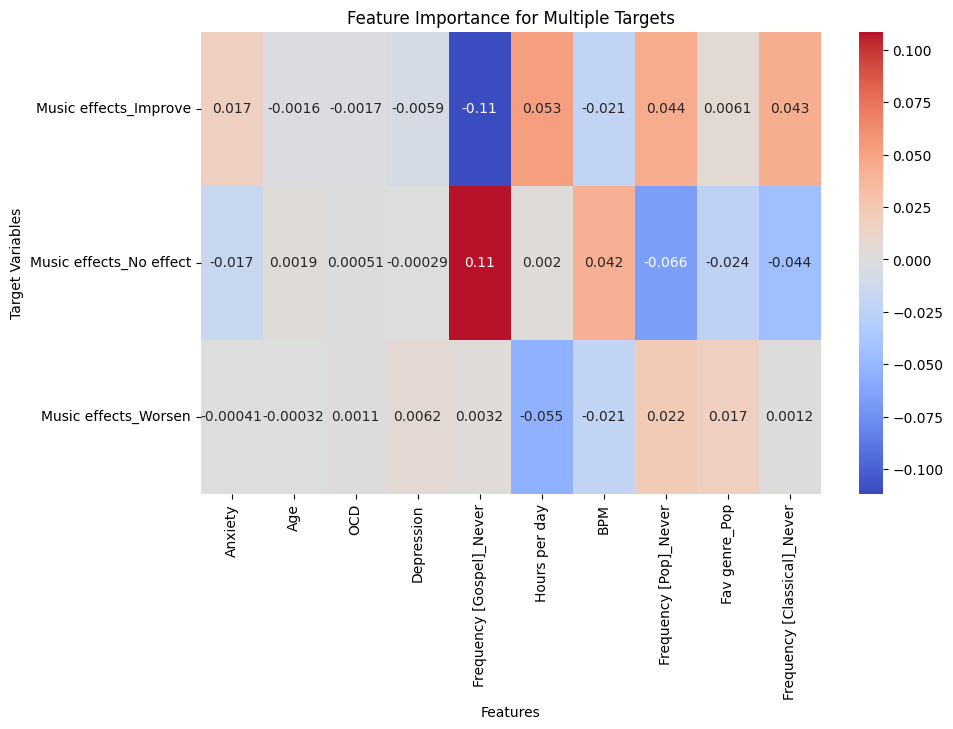

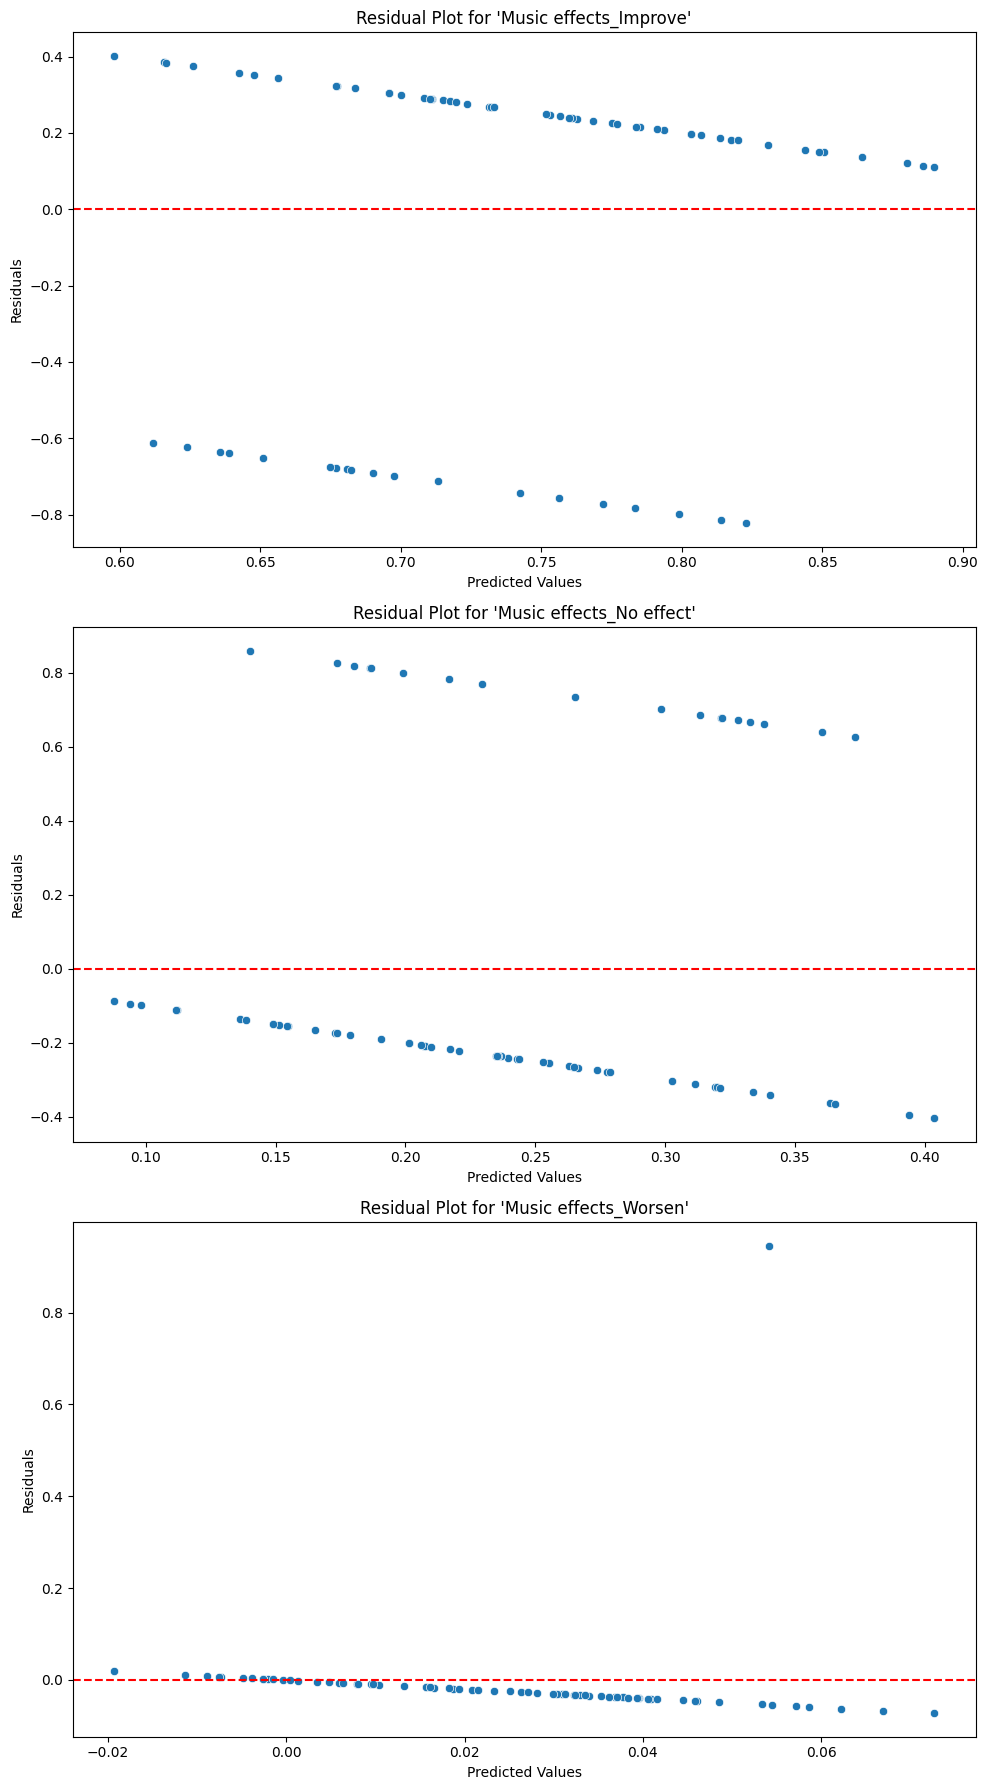

*********Residual plots on categorical target*********

Root Mean Squared Error (RMSE) for 'Music effects_Improve': 0.42603816739377237
Root Mean Squared Error (RMSE) for 'Music effects_No effect': 0.42079733271375136
Root Mean Squared Error (RMSE) for 'Music effects_Worsen': 0.11437310924701843


**********l2 Regularization*********

Ridge Model - Root Mean Squared Error: 0.35195819723618105
Ridge Model - R^2 Score: 0.03510207614192359


**********l1 Regularization*********

Lasso with Lower Alpha - RMSE: 0.3544608903413442, R^2: 0.026615621949344376


**********Polynomial Regression*********

Polynomial Regression - RMSE: 0.351975436365514, R^2: 0.035216288051150325


Saving SHAP Force Plot for Target: Music effects_Improve
Force plot for Music effects_Improve saved as force_plot_target_0.html
------------------------------------------------------------------------------------------


Saving SHAP Force Plot for Target: Music effects_No effect
Force plot for Music effects_No effect sa

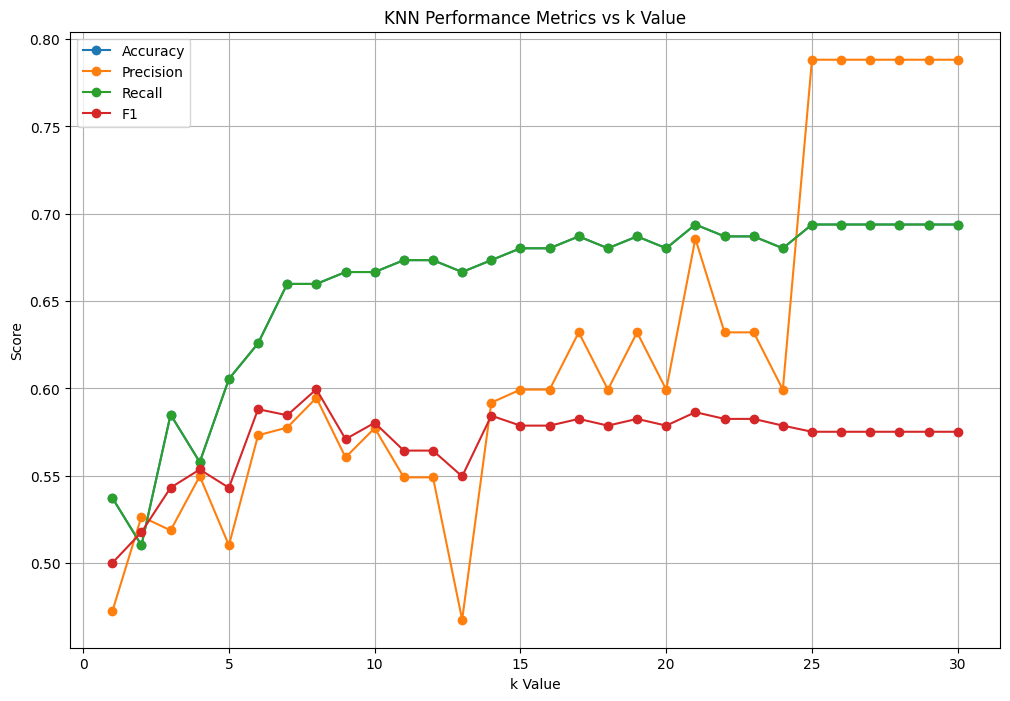


Optimal k value based on accuracy: 21

Metrics for KNN (k=21):
Accuracy: 0.694
Precision: 0.686
Recall: 0.694
F1-score: 0.586

Model Comparison:
            Model  Accuracy  Precision   Recall  F1-Score
    Decision Tree  0.523810   0.544974 0.523810  0.533039
    Random Forest  0.673469   0.549094 0.673469  0.564430
Gradient Boosting  0.666667   0.588681 0.666667  0.588941
       KNN (k=21)  0.693878   0.685752 0.693878  0.586422


In [25]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
import shap
from sklearn.tree import DecisionTreeClassifier

# dataset loaded
df = pd.read_csv('mxmh_survey_results.csv')
#----------------------------------Handling missing values of Age feature -----------------------------------------------------------------------------
# Selecting relevant numeric columns for imputation
numeric_cols = ['Age', 'Hours per day', 'BPM', 'Anxiety', 'Depression', 'Insomnia', 'OCD']
df_numeric = df[numeric_cols]

# Initializing KNN Imputer
imputer = KNNImputer(n_neighbors=5)

# Performing KNN imputation
imputed_data = imputer.fit_transform(df_numeric)

print("Imputed data based on prediction\n",imputed_data)
print("\n")
# Creating a new dataframe with imputed values
df_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)


# Replacing the original 'Age' column with the imputed values
df['Age'] = df_imputed['Age']
df['Age'] = df['Age'].astype(int)


#-----------------------------------------Handling missing values of categorical features---------------------------------------------------------
# Filling missing values using forward fill
df['Primary streaming service'] = df['Primary streaming service'].ffill()
df['While working']=df['While working'].ffill()
df['Instrumentalist'] =df['Instrumentalist'].ffill()
df['Composer']=df['Composer'].ffill()
df['Composer']=df['Composer'].ffill()

#--------------------------------------Handling missing value of BPM feature-------------------------------------------------------------------
## 1. Spliting data into rows with and without missing values
train_data = df[df['BPM'].notnull()]
missing_data = df[df['BPM'].isnull()]

#Features used to predict values of BPM
categorical_columns = ['Frequency [Classical]', 'Frequency [Country]', 'Frequency [EDM]',
'Frequency [Folk]', 'Frequency [Gospel]','Frequency [Hip hop]','Frequency [Jazz]',
'Frequency [K pop]','Frequency [Latin]','Frequency [Lofi]','Frequency [Metal]',
'Frequency [Pop]','Frequency [R&B]','Frequency [Rap]','Frequency [Rock]','Frequency [Video game music]'
]

# One-hot encoding categorical columns for training and missing data
train_data_encoded = pd.get_dummies(train_data, columns=categorical_columns, drop_first=True)
missing_data_encoded = pd.get_dummies(missing_data, columns=categorical_columns, drop_first=True)

# Align columns in missing_data_encoded to match the columns in train_data_encoded
missing_data_encoded = missing_data_encoded.reindex(columns=train_data_encoded.columns, fill_value=0)

# Features which have less correlation with feature BPM
col = ['Timestamp','Age','Primary streaming service','Hours per day',
'While working','Instrumentalist','Composer',
'Fav genre','Exploratory','Foreign languages','BPM','Anxiety',
'Depression','Insomnia','OCD','Music effects']

# Splitting into features and target
X_train = train_data_encoded.drop(col, axis=1) # Features for training
y_train = train_data_encoded['BPM'] #Target (BPM)
X_missing = missing_data_encoded.drop(col, axis=1) # Features for missing data

# Train a RandomForestRegressor model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict the missing BPM values
predicted_values = model.predict(X_missing)

# Fill missing values in the original dataframe
df.loc[df['BPM'].isnull(), 'BPM'] = predicted_values
#-----------------------------------Handling missing value of Music effects feature--------------------------------------------------------------
# Fill missing values temporarily with 'Unknown' for encoding
df['Music effects']= df['Music effects'].fillna('Unknown')

# Encode the 'Music effects' column
label_encoder = LabelEncoder()
df['Music effects'] = label_encoder.fit_transform(df['Music effects'])

# Select features for prediction (you can add more relevant features)
features = ['Age', 'Hours per day', 'Anxiety', 'Depression', 'Insomnia', 'OCD']

# Prepare the data for training
known_data = df[df['Music effects'] != label_encoder.transform(['Unknown'])[0]]
unknown_data = df[df['Music effects'] == label_encoder.transform(['Unknown'])[0]]

X_known = known_data[features]
y_known = known_data['Music effects']
X_unknown = unknown_data[features]

# Train a Random Forest Classifier
X_train, X_test, y_train, y_test = train_test_split(X_known, y_known, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict missing 'Music effects' values if X_unknown is not empty
if not X_unknown.empty:
    y_pred_unknown = rf_model.predict(X_unknown)
    df.loc[df['Music effects'] == label_encoder.transform(['Unknown'])[0], 'Music effects'] = y_pred_unknown

# Decode the 'Music effects' column back to original labels
df['Music effects'] = label_encoder.inverse_transform(df['Music effects'])

#----------------------------------------removing noise and scaling numerical features-------------------------------------------------------------------------
scaler = MinMaxScaler()

# Removes rows where BPM is above 200
df = df[df['BPM'] < 250]  # Removes rows where BPM is above 200

# Scale features using Normalization
numeric_cols = ['BPM', 'Hours per day']
df.loc[:, numeric_cols] = scaler.fit_transform(df.loc[:, numeric_cols])
#----------------------------------------------Encoding categorical features-----------------------------------------------------


categorical_cols = ['Primary streaming service', 'While working','Instrumentalist','Composer','Fav genre'
,'Exploratory','Foreign languages','Frequency [Classical]','Frequency [Country]', 'Frequency [EDM]',
'Frequency [Folk]', 'Frequency [Gospel]','Frequency [Hip hop]','Frequency [Jazz]',
'Frequency [K pop]','Frequency [Latin]','Frequency [Lofi]','Frequency [Metal]',
'Frequency [Pop]','Frequency [R&B]','Frequency [Rap]','Frequency [Rock]','Frequency [Video game music]','Music effects']
numerical_cols = ['Age', 'Hours per day','BPM','Anxiety', 'Depression', 'Insomnia', 'OCD']



EncodedDF = pd.get_dummies(df, columns=categorical_cols)
EncodedDF.drop(columns=['Timestamp'], inplace=True)

#---------------------------Decision tree model(feature selection)----------------------------------------------------------
dropFeatures = ['Music effects_Improve','Music effects_No effect','Music effects_Worsen']
X = EncodedDF.drop(columns=dropFeatures)
y = EncodedDF[dropFeatures]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)

# Fit the model on the training data
dt_model.fit(X_train, y_train)

importances = dt_model.feature_importances_

# Create a DataFrame to view feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
     'Coefficient': importances
}).sort_values(by='Coefficient', ascending=False)

print("Selected features based on decision tree\n\n",feature_importance_df['Feature'].head(10).tolist())

#--------------------------------------------Linear Regression----------------------------------
X_selected=X[feature_importance_df['Feature'].head(10)]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.1, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("**********Linear Regression*********\n")
print("Root Mean Squared Error (MSE):", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R^2 Score:", r2_score(y_test, y_pred))
print("\n")
#---------------------------Cross-validation------------------------------------------------------

rf_model = RandomForestClassifier(random_state=42)
cv_scores = cross_val_score(rf_model, X_selected, y, cv=5, scoring='accuracy')
print("**********Cross Validation*********\n")
# Print out the accuracy for each fold
print("Cross-validation scores for each fold:", cv_scores)

# Compute the average accuracy across all folds
average_accuracy = cv_scores.mean()
print("**********Cross fold validation*********\n")
print(f"Average accuracy across all folds: {average_accuracy:.4f}")
print("\n")
#--------------------------------------feature importance heat map---------------------------------------------------------

coefficients_df = pd.DataFrame(model.coef_, columns=X_selected.columns)
coefficients_df.index = dropFeatures

plt.figure(figsize=(10, 6))
sns.heatmap(coefficients_df, annot=True, cmap="coolwarm", center=0)
plt.title("Feature Importance for Multiple Targets")
plt.xlabel("Features")
plt.ylabel("Target Variables")
plt.show()
#-------------------------------residual plot----------------------------------------------------------
# Predictions
y_pred = model.predict(X_test)

# Calculate residuals for each target variable
residuals_improve = y_test['Music effects_Improve'] - y_pred[:, 0]
residuals_no_effect = y_test['Music effects_No effect'] - y_pred[:, 1]
residuals_worsen = y_test['Music effects_Worsen'] - y_pred[:, 2]

# Plotting residuals for each target variable
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Residual Plot for 'Music effects_Improve'
sns.scatterplot(x=y_pred[:, 0], y=residuals_improve, ax=axs[0])
axs[0].axhline(y=0, color='r', linestyle='--')
axs[0].set_title("Residual Plot for 'Music effects_Improve'")
axs[0].set_xlabel("Predicted Values")
axs[0].set_ylabel("Residuals")

# Residual Plot for 'Music effects_No effect'
sns.scatterplot(x=y_pred[:, 1], y=residuals_no_effect, ax=axs[1])
axs[1].axhline(y=0, color='r', linestyle='--')
axs[1].set_title("Residual Plot for 'Music effects_No effect'")
axs[1].set_xlabel("Predicted Values")
axs[1].set_ylabel("Residuals")

# Residual Plot for 'Music effects_Worsen'
sns.scatterplot(x=y_pred[:, 2], y=residuals_worsen, ax=axs[2])
axs[2].axhline(y=0, color='r', linestyle='--')
axs[2].set_title("Residual Plot for 'Music effects_Worsen'")
axs[2].set_xlabel("Predicted Values")
axs[2].set_ylabel("Residuals")

# Adjust layout and show plots
plt.tight_layout()
plt.show()

print("*********Residual plots on categorical target*********\n")
print("Root Mean Squared Error (RMSE) for 'Music effects_Improve':", np.sqrt(mean_squared_error(y_test['Music effects_Improve'], y_pred[:, 0])))
print("Root Mean Squared Error (RMSE) for 'Music effects_No effect':", np.sqrt(mean_squared_error(y_test['Music effects_No effect'], y_pred[:, 1])))
print("Root Mean Squared Error (RMSE) for 'Music effects_Worsen':", np.sqrt(mean_squared_error(y_test['Music effects_Worsen'], y_pred[:, 2])))
print("\n")
#------------------------------------------l2 Regularization------------------------------------------------------
ridge_model = Ridge(alpha=1.0)

# Fit the model to the training data
ridge_model.fit(X_train, y_train)

# Make predictions
y_pred_ridge = ridge_model.predict(X_test)

# Evaluate the model
print("**********l2 Regularization*********\n")
print("Ridge Model - Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("Ridge Model - R^2 Score:", r2_score(y_test, y_pred_ridge))
print("\n")

#--------------------------------------------------l1 Regularization-----------------------------------------------------
lasso_model = Lasso(alpha=0.01, positive=True)
lasso_model.fit(X_train, y_train)

y_pred_lasso = lasso_model.predict(X_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

print("**********l1 Regularization*********\n")
print(f"Lasso with Lower Alpha - RMSE: {rmse_lasso}, R^2: {r2_lasso}")
print("\n")
#-------------------------------------Polynomial Regression------------------------------
poly = PolynomialFeatures(degree=1)
X_poly = poly.fit_transform(X_train)
poly_model = LinearRegression()
poly_model.fit(X_poly, y_train)

X_test_poly = poly.transform(X_test)
y_pred_poly = poly_model.predict(X_test_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
r2_poly = r2_score(y_test, y_pred_poly)
print("**********Polynomial Regression*********\n")
print(f"Polynomial Regression - RMSE: {rmse_poly}, R^2: {r2_poly}")
print("\n")

#---------------------------------------------Shap package for reporting-------------------------------------------------------
model = LinearRegression()
model.fit(X_train, y_train)
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer(X_test)
sample_idx = 0  # Index of the sample to explain (change as needed)
for i, target in enumerate(['Music effects_Improve', 'Music effects_No effect', 'Music effects_Worsen']):
    print(f"Saving SHAP Force Plot for Target: {target}")
    force_plot = shap.force_plot(
        explainer.expected_value[i],
        shap_values.values[sample_idx, :, i],
        X_test.iloc[sample_idx],
        feature_names=X_test.columns
    )

    shap.save_html(f"force_plot_target_{i}.html", force_plot)
    print(f"Force plot for {target} saved as force_plot_target_{i}.html")
    print("------------------------------------------------------------------------------------------")
    print("\n")

#-------------------------------------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------------------------------------

# Exercise Day 8 : Tree and KNN classification
# Following the outcomes of the previous group exercise

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Defining categorical columns
categorical_cols = ['Primary streaming service', 'While working', 'Instrumentalist',
                   'Composer', 'Fav genre', 'Exploratory', 'Foreign languages',
                   'Frequency [Classical]', 'Frequency [Country]', 'Frequency [EDM]',
                   'Frequency [Folk]', 'Frequency [Gospel]', 'Frequency [Hip hop]',
                   'Frequency [Jazz]', 'Frequency [K pop]', 'Frequency [Latin]',
                   'Frequency [Lofi]', 'Frequency [Metal]', 'Frequency [Pop]',
                   'Frequency [R&B]', 'Frequency [Rap]', 'Frequency [Rock]',
                   'Frequency [Video game music]', 'Music effects']

# Creating EncodedDF with one-hot encoding
EncodedDF = pd.get_dummies(df, columns=categorical_cols)
EncodedDF.drop(columns=['Timestamp'], inplace=True)

# Preparing features and target
X = EncodedDF.drop(columns=['Music effects_Improve', 'Music effects_No effect', 'Music effects_Worsen'])
y = EncodedDF['Music effects_Improve']

# Spliting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Exercise Day 8 : Tree and KNN classification")
print("Following the outcomes of the previous group exercise")

# Implementing Tree Models
def train_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\nMetrics for {model_name}:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-score: {f1:.3f}")

    return accuracy, precision, recall, f1

# Training and evaluating tree models
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

dt_metrics = train_evaluate_model(dt_model, X_train_scaled, X_test_scaled, y_train, y_test, "Decision Tree")
rf_metrics = train_evaluate_model(rf_model, X_train_scaled, X_test_scaled, y_train, y_test, "Random Forest")
gb_metrics = train_evaluate_model(gb_model, X_train_scaled, X_test_scaled, y_train, y_test, "Gradient Boosting")

# KNN Model and Optimal k Selection
k_values = range(1, 31)
knn_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)

    knn_metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    knn_metrics['precision'].append(precision_score(y_test, y_pred, average='weighted'))
    knn_metrics['recall'].append(recall_score(y_test, y_pred, average='weighted'))
    knn_metrics['f1'].append(f1_score(y_test, y_pred, average='weighted'))

# Ploting KNN metrics
plt.figure(figsize=(12, 8))
for metric, scores in knn_metrics.items():
    plt.plot(k_values, scores, marker='o', label=metric.capitalize())

plt.xlabel('k Value')
plt.ylabel('Score')
plt.title('KNN Performance Metrics vs k Value')
plt.legend()
plt.grid(True)
plt.show()

# Finding optimal k
optimal_k = k_values[np.argmax(knn_metrics['accuracy'])]
print(f"\nOptimal k value based on accuracy: {optimal_k}")

# Training final KNN model with optimal k
final_knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn_metrics = train_evaluate_model(final_knn, X_train_scaled, X_test_scaled, y_train, y_test, f"KNN (k={optimal_k})")

# Creating comparison table
models_comparison = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'Gradient Boosting', f'KNN (k={optimal_k})'],
    'Accuracy': [dt_metrics[0], rf_metrics[0], gb_metrics[0], knn_metrics[0]],
    'Precision': [dt_metrics[1], rf_metrics[1], gb_metrics[1], knn_metrics[1]],
    'Recall': [dt_metrics[2], rf_metrics[2], gb_metrics[2], knn_metrics[2]],
    'F1-Score': [dt_metrics[3], rf_metrics[3], gb_metrics[3], knn_metrics[3]]
})

print("\nModel Comparison:")
print(models_comparison.to_string(index=False))
